In [8]:
## Plot the positions of the co-eQTLs in Manhattan / Location Plots

# Libraries

In [9]:
source('MS0_Libraries.r')

Warning message in read.table(file = file, header = header, sep = sep, quote = quote, :
"incomplete final line found by readTableHeader on '../conda_environment/Environment_Configs.csv'"


[1] "/home/icb/corinna.losert/miniconda3/envs/scgrn_R_4_1//lib/R/library"


In [10]:
source('MS4_Plot_Config.r')

# Parameters

In [ ]:
### Define for which cell-type to execute

In [347]:
cell_type = 'Mono'

In [11]:
### Path to the co-EQTL Files

In [12]:
data_path = '../data/current/coeqtl_mapping/'

In [18]:
coeqtl_mapping = 'co_qtls_sceqtlgen'

In [19]:
coeqtl_results_path = 'co_qtls_decision_tree/'   # path to new results

In [ ]:
### Path to the eQTL Files (sceQTLGen)

In [13]:
data_path_eqtl = '../data/current/eqtl_mapping/'

In [14]:
eqtl_results = 'sc_eqtlgen_final'

In [ ]:
### Parameters for which multiple testing correction to use

In [20]:
n_sample_filter = 133

In [21]:
p_val_column = 'p_val_mt_eGene' # p_value # nominal, p_val_mt_eGene

In [348]:
n_rb_mt_filter = FALSE

# Data

### Get significant co-eQTLs

In [1]:
### From meta-analysis

In [350]:
meta_results = fread(paste0( "../data/current/coeqtl_mapping/", coeqtl_results_path , "/shared_results/", '5DS_Meta_Analysis_Sign_coeQTLs', n_sample_filter, p_val_column  ,'.csv'))

In [351]:
meta_results = as.data.frame(meta_results)

In [352]:
### Define ribosomal non ribosomal genes

In [353]:
meta_results$n_rb_mt = 0
meta_results$n_rb_mt[(meta_results$eGene_rib ==0) & (meta_results$coeGene_rib == 0) & (meta_results$eGene_mt == 0) & (meta_results$coeGene_mt == 0)] = 1

In [354]:
### Filter on non ribosomal genes
if(n_rb_mt_filter == TRUE){
    meta_results = meta_results[meta_results$n_rb_mt == 1,]
    }

In [357]:
### Filter on selected cell-type

In [358]:
meta_results = meta_results[meta_results$cell_type == cell_type,]

In [359]:
head(meta_results,2)

,V1,eGene,coeGene,snp_id,triplet,cell_type,dataset,feature_id,n_samples,p_val_mt,⋯,z_score;oneK1K;CD8_T,z_score;oneK1K;Mono,z_score;oneK1K;NK,z_score;wijst;B,z_score;wijst;CD4_T,z_score;wijst;CD8_T,z_score;wijst;Mono,z_score;wijst;NK,remap_overlap_tf_snp,n_rb_mt
,<int>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<int>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>
99,99,ACSL5,VIM,10:112347540:T:C,10:112347540:T:C;ACSL5_VIM,Mono,meta_5ds,ACSL5_VIM,337,4.771307,⋯,NA,3.674231,NA,NA,NA,NA,NA,NA,NA,0
111,111,ADK,TEX264,10:74728830:CA:C,10:74728830:CA:C;ADK_TEX264,Mono,meta_5ds,ADK_TEX264,300,1.816878,⋯,NA,-5.874769,NA,NA,NA,NA,NA,NA,NA,1


### Get the chromosome sizes object

In [361]:
chromsomeSizes = fread(paste0(  "../data/current/meta-data/", "chromosome_sizes.txt"))

In [362]:
chromsomeSizes = as.data.frame(chromsomeSizes)

In [363]:
head(chromsomeSizes,2)

,Chromosome,Length (mm),Base pairs
,<int>,<int>,<int>
1,1,85,248956422
2,2,83,242193529


In [364]:
colnames(chromsomeSizes ) = c('chr', 'length', 'base_pairs')

In [365]:
chromsomeSizes$cumulative_bp <- cumsum(as.numeric(chromsomeSizes$base_pairs))

In [366]:
# Create a new column 'shifted_cumulative_bp' that shifts 'cumulative_bp' up by one row
chromsomeSizes$cumulative_bp <- c(0, chromsomeSizes$cumulative_bp[-nrow(chromsomeSizes)])

# Data preparation

## Get positions of coeGenes

In [367]:
### Genes

In [368]:
genes = unique(meta_results$coeGene)

In [369]:
# Connect to the Ensembl BioMart database
mart <- useMart("ENSEMBL_MART_ENSEMBL")
dataset <- useDataset("hsapiens_gene_ensembl", mart)

In [370]:
# Specify the attributes to retrieve: gene symbols, start, and end positions
attributes <- c("hgnc_symbol", "ensembl_gene_id", "start_position", "end_position", "chromosome_name")

# Retrieve the gene information
gene_locations <- getBM(attributes = attributes,
                        mart = dataset)

# View the first few rows of the results
head(gene_locations)

,hgnc_symbol,ensembl_gene_id,start_position,end_position,chromosome_name
,<chr>,<chr>,<int>,<int>,<chr>
1,MT-TF,ENSG00000210049,577,647,MT
2,MT-RNR1,ENSG00000211459,648,1601,MT
3,MT-TV,ENSG00000210077,1602,1670,MT
4,MT-RNR2,ENSG00000210082,1671,3229,MT
5,MT-TL1,ENSG00000209082,3230,3304,MT
6,MT-ND1,ENSG00000198888,3307,4262,MT


In [371]:
### Get the locations for coeGenes

In [372]:
gene_locations_co = gene_locations[gene_locations$hgnc_symbol %in% genes,]
gene_locations_co_ens = gene_locations[gene_locations$ensembl_gene_id %in% genes,]

In [373]:
gene_locations_co = gene_locations_co[gene_locations_co$chromosome_name %in% c(1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24, 'X'),]

In [374]:
nrow(gene_locations_co)
nrow(gene_locations_co_ens)

[1] 625

[1] 10

In [375]:
unique(gene_locations_co_ens$chromosome_name)

[1] "12" "14" "10" "17" "11" "1"

In [376]:
unique(gene_locations_co$chromosome_name)

[1] "21" "13" "20" "22" "X"  "18" "8"  "19" "16" "12" "5"  "6"  "10" "17" "4" 
[16] "3"  "7"  "11" "9"  "2"  "1"  "15" "14"

In [377]:
### remove duplicats
length(unique(gene_locations_co_ens$ensembl_gene_id))

[1] 10

In [378]:
length(unique(gene_locations_co$hgnc_symbol))

[1] 624

In [379]:
gene_locations_co %>% group_by(hgnc_symbol) %>% dplyr::count() %>% dplyr::filter(n >=2)

hgnc_symbol,n
<chr>,<int>
HLA-DRB6,2


In [380]:
## remove duplicates by taking mean
gene_locations_co = gene_locations_co %>% group_by(hgnc_symbol,  chromosome_name) %>% summarise(start_position = mean(start_position), end_position = mean(end_position))

`summarise()` has grouped output by 'hgnc_symbol'. You can override using the
`.groups` argument.


In [381]:
## merge the ensembl-mapped and symbol mapped locations

In [382]:
gene_locations_co_ens$hgnc_symbol = gene_locations_co_ens$ensembl_gene_id
gene_locations_co_ens$ensembl_gene_id = NULL

In [383]:
head(gene_locations_co_ens,2)

,hgnc_symbol,start_position,end_position,chromosome_name
,<chr>,<int>,<int>,<chr>
10564,ENSG00000257764,69353493,69354225,12
45807,ENSG00000258666,100333790,100354061,14


In [384]:
gene_locations_co$ensembl_gene_id = NULL

In [385]:
gene_locations = rbind(gene_locations_co, gene_locations_co_ens)

In [389]:
gene_locations$mean_position = (gene_locations$start_position + gene_locations$end_position ) / 2

## Merge gene positions to significant co-eQTLs and calculate the start/ end positions for plotting

In [390]:
head(meta_results,2)

,V1,eGene,coeGene,snp_id,triplet,cell_type,dataset,feature_id,n_samples,p_val_mt,⋯,z_score;oneK1K;CD8_T,z_score;oneK1K;Mono,z_score;oneK1K;NK,z_score;wijst;B,z_score;wijst;CD4_T,z_score;wijst;CD8_T,z_score;wijst;Mono,z_score;wijst;NK,remap_overlap_tf_snp,n_rb_mt
,<int>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<int>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>
99,99,ACSL5,VIM,10:112347540:T:C,10:112347540:T:C;ACSL5_VIM,Mono,meta_5ds,ACSL5_VIM,337,4.771307,⋯,NA,3.674231,NA,NA,NA,NA,NA,NA,NA,0
111,111,ADK,TEX264,10:74728830:CA:C,10:74728830:CA:C;ADK_TEX264,Mono,meta_5ds,ADK_TEX264,300,1.816878,⋯,NA,-5.874769,NA,NA,NA,NA,NA,NA,NA,1


In [391]:
meta_results = merge(meta_results, gene_locations, by.x = 'coeGene', by.y = 'hgnc_symbol', all.x = TRUE)

In [ ]:
## Extract chromosome and position

In [393]:
meta_results$snp_chr = str_replace(meta_results$snp_id, ':.*', '')
meta_results$snp_pos = str_extract(meta_results$snp_id, ':.*:')

In [394]:
meta_results$snp_pos = str_extract(meta_results$snp_pos, ':(\\d+):')

In [395]:
meta_results$snp_pos = str_replace_all(meta_results$snp_pos, ':', '')

In [396]:
head(meta_results,2)

,coeGene,V1,eGene,snp_id,triplet,cell_type,dataset,feature_id,n_samples,p_val_mt,⋯,z_score;wijst;Mono,z_score;wijst;NK,remap_overlap_tf_snp,n_rb_mt,chromosome_name,start_position,end_position,mean_position,snp_chr,snp_pos
,<chr>,<int>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<int>,<dbl>,⋯,<dbl>,<dbl>,<chr>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<chr>
1,ABHD3,5047,GSTP1,11:67584785:C:A,11:67584785:C:A;ABHD3_GSTP1,Mono,meta_5ds,ABHD3_GSTP1,535,1.807372e-05,⋯,NA,NA,NA,0,18,21650901,21704780,21677840,11,67584785
2,ABI3,10952,PAM,5:102782929:T:C,5:102782929:T:C;ABI3_PAM,Mono,meta_5ds,ABI3_PAM,242,1.026462e-07,⋯,NA,NA,NA,1,17,49210411,49223225,49216818,5,102782929


In [397]:
### Merge the chromosome sizes for snp and genes

In [398]:
head(chromsomeSizes,2)

,chr,length,base_pairs,cumulative_bp
,<int>,<int>,<int>,<dbl>
1,1,85,248956422,0
2,2,83,242193529,248956422


In [399]:
chromsomeSizes$chr = as.character(chromsomeSizes$chr)

In [400]:
nrow(meta_results)

[1] 4323

In [401]:
meta_results = merge(meta_results, chromsomeSizes, by.x = 'snp_chr', by.y = 'chr', all.x = TRUE)  ## merge for the snp

In [402]:
meta_results = merge(meta_results, chromsomeSizes, by.x = 'chromosome_name', by.y = 'chr', all.x = TRUE)  ## merge for the gene

In [403]:
nrow(meta_results)

[1] 4323

In [405]:
head(meta_results,2)

,chromosome_name,snp_chr,coeGene,V1,eGene,snp_id,triplet,cell_type,dataset,feature_id,⋯,start_position,end_position,mean_position,snp_pos,length.x,base_pairs.x,cumulative_bp.x,length.y,base_pairs.y,cumulative_bp.y
,<chr>,<chr>,<chr>,<int>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,⋯,<dbl>,<dbl>,<dbl>,<chr>,<int>,<int>,<dbl>,<int>,<int>,<dbl>
1,1,6,FCGR3A,6151,HLA-C,6:31306778:C:T,6:31306778:C:T;FCGR3A_HLA-C,Mono,meta_5ds,FCGR3A_HLA-C,⋯,161541759,161550968,161546364,31306778,58,170805979,1061198324,85,248956422,0
2,1,12,UQCRH,83973,RPS26,12:56042145:C:G,12:56042145:C:G;RPS26_UQCRH,Mono,meta_5ds,RPS26_UQCRH,⋯,46303698,46316776,46310237,56042145,45,133275309,1943767673,85,248956422,0


In [406]:
### Define positions to plot for coGene and SNP (add the amount of basepairs from the previous chromosome)

In [407]:
meta_results$snp_pos_plot = as.numeric(meta_results$snp_pos) + meta_results$cumulative_bp.x 
meta_results$cogene_pos_plot = meta_results$mean_position + meta_results$cumulative_bp.y 

## Generate dotplot

In [408]:
### Generate custom tick labels (where to label the chromosomes)

In [409]:
ticks_x_y = unique(chromsomeSizes[,c('chr', 'cumulative_bp')])

In [412]:
ticks_x_y$snp_chr = as.numeric(ticks_x_y$chr)

In [413]:
head(ticks_x_y,2)

,chr,cumulative_bp,snp_chr
,<chr>,<dbl>,<dbl>
1,1,0,1
2,2,248956422,2


In [414]:
#ticks_x_y

In [415]:
# Step 1: Sort the data by `snp_chr`
ticks_x_y <- ticks_x_y[order(ticks_x_y$snp_chr), ]

# Step 2: Calculate the midpoint between previous and current rows in `cumulative_bp.x`
ticks_x_y$midpoint <- c(NA, (ticks_x_y$cumulative_bp[-1] + ticks_x_y$cumulative_bp[-nrow(ticks_x_y)]) / 2)

# Shift the midpoint values up by one row
ticks_x_y$midpoint <- c(ticks_x_y$midpoint[-1], NA)


In [416]:
ticks_x_y$midpoint[ticks_x_y$snp_chr == 22] = (ticks_x_y$cumulative_bp[ticks_x_y$snp_chr == 22] + (50818468/2))

In [417]:
## Calculate the endpoints

In [418]:
ticks_x_y$endpoint <- c(ticks_x_y$cumulative_bp[-1], NA)

In [419]:
ticks_x_y$endpoint[ticks_x_y$snp_chr == 22] = ticks_x_y$endpoint[ticks_x_y$snp_chr == 21] + 50818468

In [420]:
### Generate plot

Warning message:
"Removed 350 rows containing missing values or values outside the scale range
(`geom_point()`)."


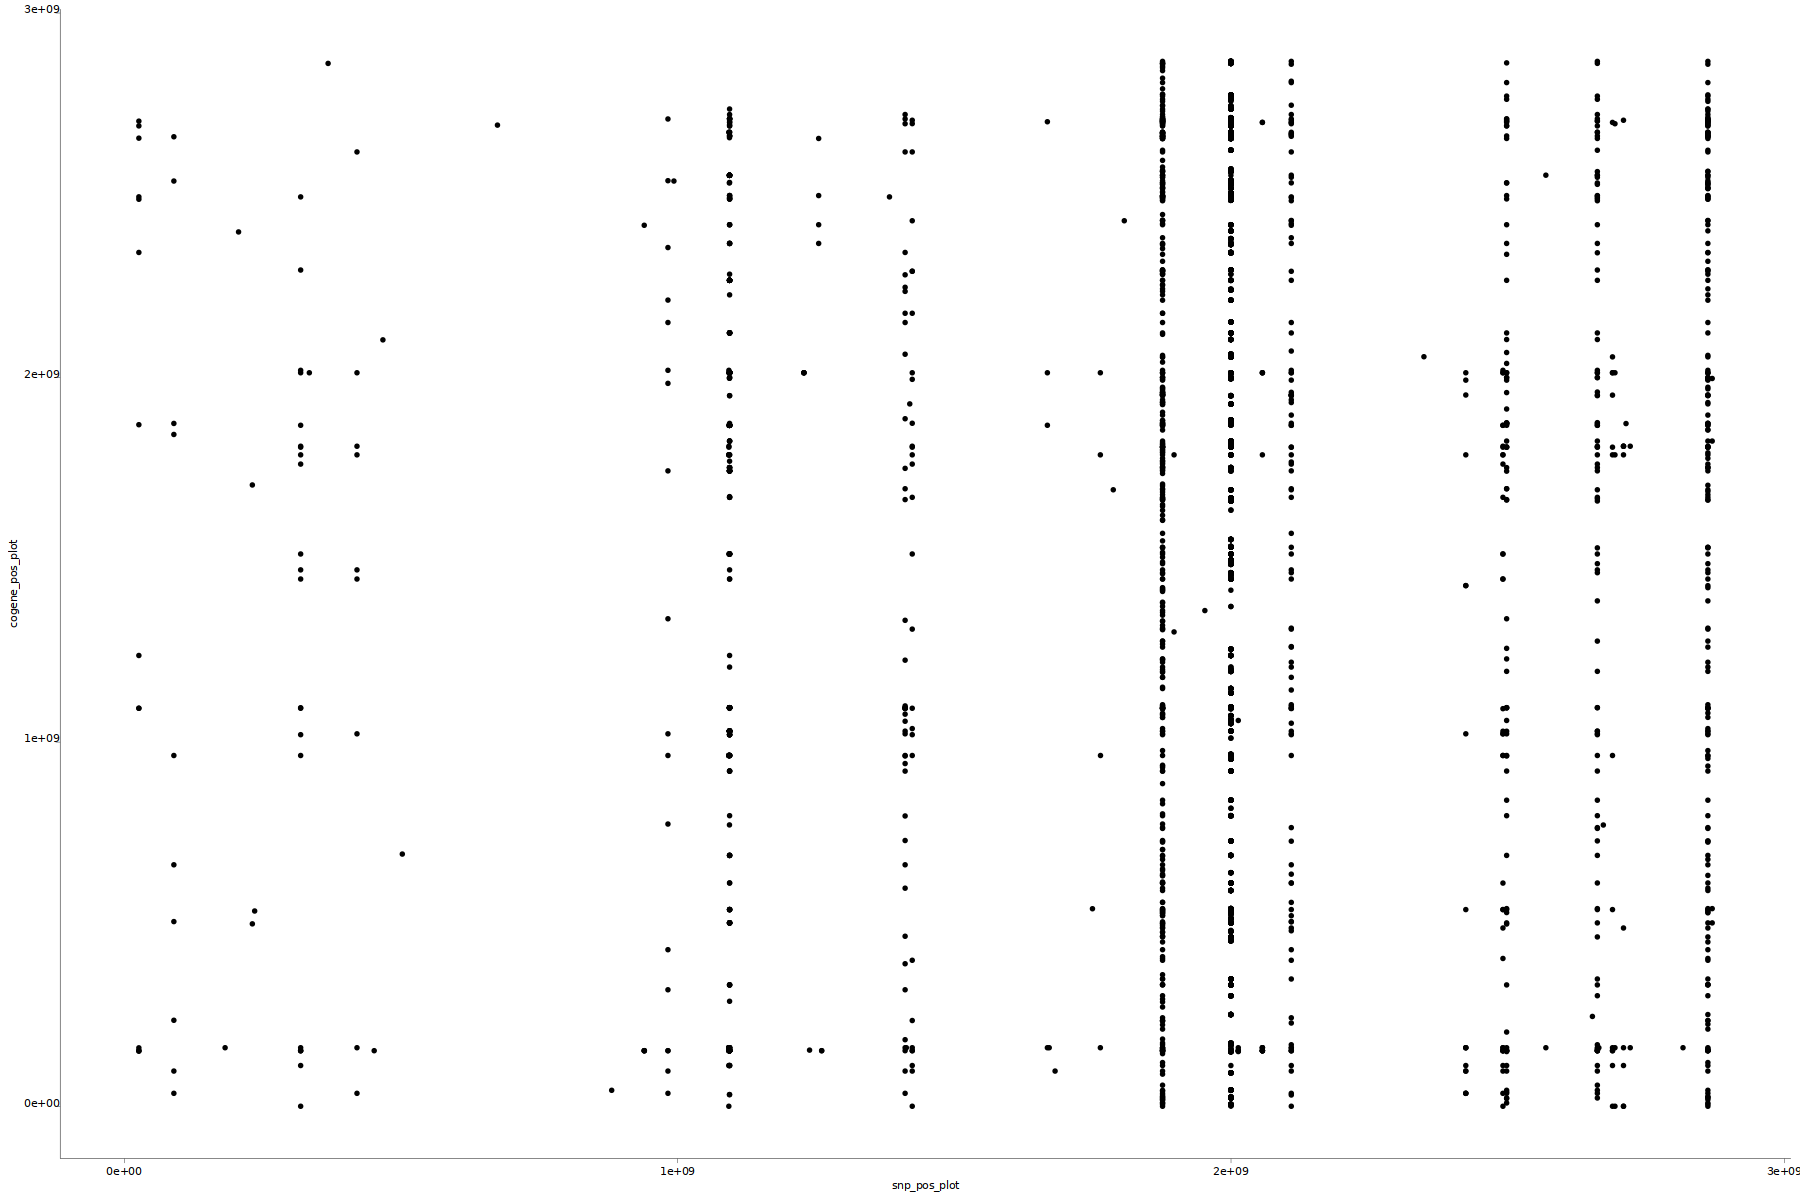

In [421]:
options(repr.plot.width=15, repr.plot.height=10)
dotplot = ggplot(meta_results , aes(snp_pos_plot, cogene_pos_plot)) + geom_point(size = 0.5) +   #aes(size = -log10(p_value)
    scale_size_continuous(range = c(0.1, 1)) + theme(axis.text.x = element_blank(), axis.text.y = element_blank()) + plot_config  + scale_color_gradient(low = "lightblue", high = "blue")

dotplot

In [422]:
# Add vertical lines at specified x positions
for (x_pos in unique(chromsomeSizes$cumulative_bp )) {
  dotplot <- dotplot + geom_vline(xintercept = x_pos, color = "grey", size = 0.5)
}

In [423]:
# Add horizontal lines at specified y positions
for (y_pos in unique(chromsomeSizes$cumulative_bp )) {
  dotplot <- dotplot + geom_hline(yintercept = y_pos, color = "grey", size = 0.5)
}

In [424]:
## Modify axis ticks to show chromosome 

In [425]:
dotplot = dotplot + 
  scale_x_continuous(
    limits = c(0, max(meta_results$cumulative_bp.x) + 50818468), 
    expand = c(0, 0),  breaks = ticks_x_y$midpoint, labels = ticks_x_y$snp_chr
  ) +
  scale_y_continuous(
    limits = c(0, max(meta_results$cumulative_bp.x) + 50818468), 
    expand = c(0, 0), breaks = ticks_x_y$midpoint, labels = ticks_x_y$snp_chr
  )  + xlab('SNP Position') + ylab('CoGene Position')


Warning message:
"Removed 350 rows containing missing values or values outside the scale range
(`geom_point()`)."


pdf 
  2

Warning message:
"Removed 350 rows containing missing values or values outside the scale range
(`geom_point()`)."


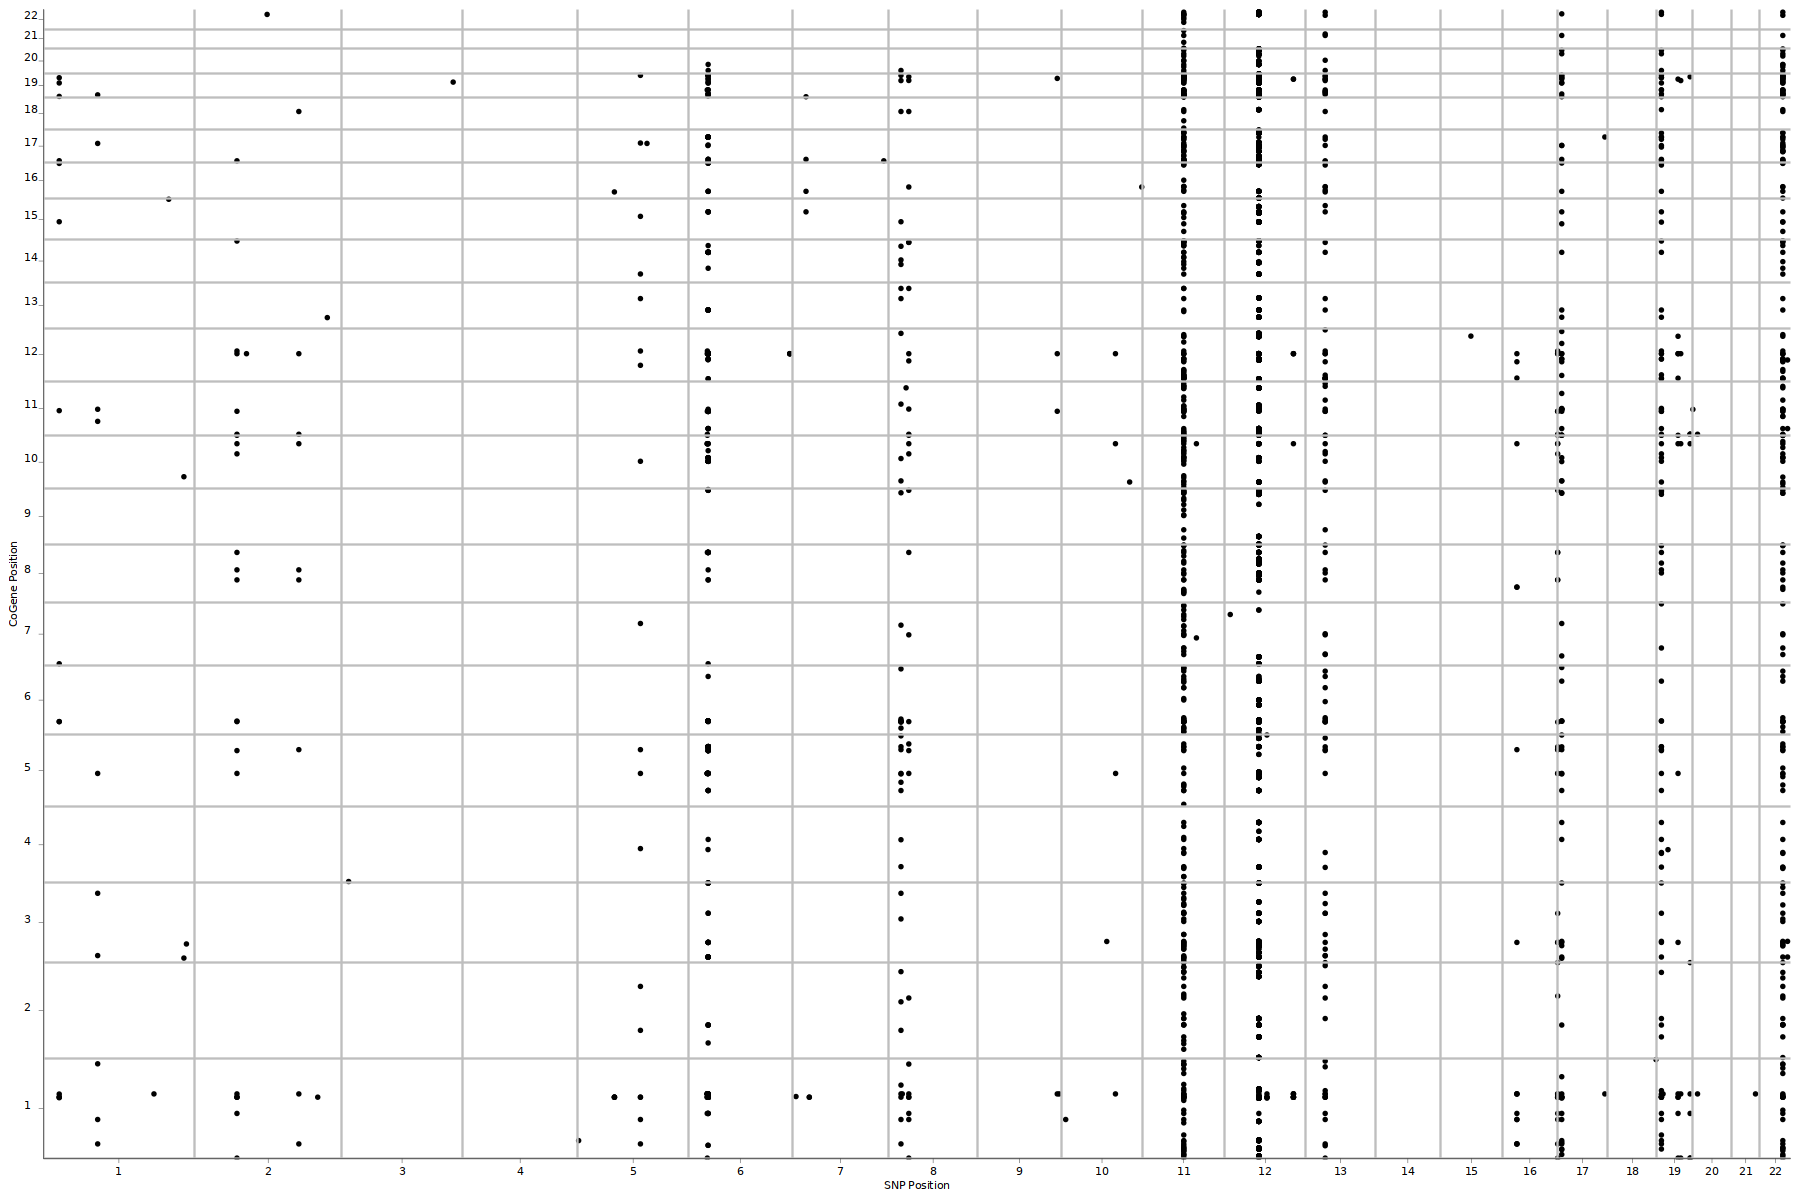

In [426]:
options(repr.plot.width=15, repr.plot.height=10)

pdf(paste0('figures/F13/F13_Dotplot_', cell_type, n_rb_mt_filter, '.pdf'), width =7.8, height =5.5)
print(dotplot)
dev.off()

dotplot 

## Generate manhattan

In [1812]:
head(meta_results,2)

,chromosome_name,snp_chr,coeGene,V1,eGene,snp_id,triplet,cell_type,dataset,feature_id,⋯,mean_position,snp_pos,length.x,base_pairs.x,cumulative_bp.x,length.y,base_pairs.y,cumulative_bp.y,snp_pos_plot,cogene_pos_plot
,<chr>,<chr>,<chr>,<int>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,⋯,<dbl>,<chr>,<int>,<int>,<dbl>,<int>,<int>,<dbl>,<dbl>,<dbl>
1,1,12,ARMH1,20175,RPS26,12:56042145:C:G,12:56042145:C:G;ARMH1_RPS26,CD4_T,meta_5ds,ARMH1_RPS26,⋯,44700142,56042145,45,133275309,1943767673,85,248956422,0,1999809818,44700142
2,1,12,SRGAP2B,77014,RPS26,12:55995509:T:C,12:55995509:T:C;RPS26_SRGAP2B,CD4_T,meta_5ds,RPS26_SRGAP2B,⋯,144991396,55995509,45,133275309,1943767673,85,248956422,0,1999763182,144991396


In [1813]:
amount_coegenes = unique(meta_results[,c('eGene', 'coeGene')]) %>% group_by(eGene) %>% summarise(amount_coegenes = n())

In [1814]:
### Set limit for RPS26 p-values

In [1815]:
meta_results$p_value[(meta_results$eGene == 'RPS26') & (meta_results$p_value < (10^-150))] = 10^-150

In [1816]:
min(meta_results$p_value[meta_results$eGene != 'RPS26'])

[1] 1.748076e-120

In [1817]:
max(-log10(meta_results$p_value[meta_results$eGene != 'RPS26']))

[1] 119.7574

In [1818]:
max(-log10(meta_results$p_value[meta_results$eGene == 'RPS26']))

[1] 150

In [1819]:
limit = 100

In [1820]:
meta_results = merge(meta_results, amount_coegenes)

In [1821]:
meta_results %>% dplyr::filter(amount_coegenes > limit) %>% group_by(eGene) %>% dplyr::filter(p_value == min(p_value)) %>%
  slice_sample(n = 1)

eGene,chromosome_name,snp_chr,coeGene,V1,snp_id,triplet,cell_type,dataset,feature_id,⋯,snp_pos,length.x,base_pairs.x,cumulative_bp.x,length.y,base_pairs.y,cumulative_bp.y,snp_pos_plot,cogene_pos_plot,amount_coegenes
<chr>,<chr>,<chr>,<chr>,<int>,<chr>,<chr>,<chr>,<chr>,<chr>,⋯,<chr>,<int>,<int>,<dbl>,<int>,<int>,<dbl>,<dbl>,<dbl>,<int>
AFAP1,1,4,S100A4,340,4:7873538:C:T,4:7873538:C:T;AFAP1_S100A4,CD4_T,meta_5ds,AFAP1_S100A4,⋯,7873538,65,190214555,689445510,85,248956422,0,697319048,153546874,158
CENPK,1,5,S100A4,1765,5:65541278:C:T,5:65541278:C:T;CENPK_S100A4,CD4_T,meta_5ds,CENPK_S100A4,⋯,65541278,62,181538259,879660065,85,248956422,0,945201343,153546874,308
EIF5A,5,17,HNRNPH1,2944,17:7304878:C:T,17:7304878:C:T;EIF5A_HNRNPH1,CD4_T,meta_5ds,EIF5A_HNRNPH1,⋯,7304878,28,83257441,2490780562,62,181538259,879660065,2498085440,1059284546,716
ENTPD1-AS1,8,10,TOX,4025,10:95814932:C:T,10:95814932:C:T;ENTPD1-AS1_TOX,CD4_T,meta_5ds,ENTPD1-AS1_TOX,⋯,95814932,46,133797422,1674883629,50,145138636,1391350276,1770698561,1450312556,101
FAM13A,18,4,BCL2,4259,4:88920782:C:G,4:88920782:C:G;BCL2_FAM13A,CD4_T,meta_5ds,BCL2_FAM13A,⋯,88920782,65,190214555,689445510,27,80373285,2574038003,778366292,2637259740,166
HLA-B,15,6,B2M,5663,6:31353491:T:G,6:31353491:T:G;B2M_HLA-B,CD4_T,meta_5ds,B2M_HLA-B,⋯,31353491,58,170805979,1061198324,35,101991189,2298451028,1092551815,2343166132,113
HLA-DRB1,1,6,S100A4,9147,6:32643457:C:T,6:32643457:C:T;HLA-DRB1_S100A4,CD4_T,meta_5ds,HLA-DRB1_S100A4,⋯,32643457,58,170805979,1061198324,85,248956422,0,1093841781,153546874,129
KCNQ5,1,6,S100A4,9741,6:72484644:T:A,6:72484644:T:A;KCNQ5_S100A4,CD4_T,meta_5ds,KCNQ5_S100A4,⋯,72484644,58,170805979,1061198324,85,248956422,0,1133682968,153546874,141
RNASET2,1,6,S100A4,15545,6:166976754:A:G,6:166976754:A:G;RNASET2_S100A4,CD4_T,meta_5ds,RNASET2_S100A4,⋯,166976754,58,170805979,1061198324,85,248956422,0,1228175078,153546874,265


In [1822]:
#scale_color_manual(values =c("CD4_T" = "#334882", "CD8_T"="#9493d8", "NK" = "#e557d6", "B" = "#ab1846", "Mono" = "#e5c157"))

In [1823]:
### Define which labels to use
if( cell_type == "CD4_T"){ choose_color = "#334882"}
if( cell_type == "CD8_T"){ choose_color = "#9493d8"}
if( cell_type == "NK"){ choose_color = "#e557d6"}
if( cell_type == "B"){ choose_color = "#ab1846"}
if( cell_type == "Mono"){ choose_color = "#e5c157"}

In [1824]:
nrow(meta_results)

[1] 49847

In [1825]:
length(unique(meta_results$feature_id))

[1] 8582

In [1826]:
#meta_results %>% group_by(feature_id) %>% dplyr::count() %>% arrange(-n)

In [1828]:
### Adjust to take only the top effect per gene-pair

In [1829]:
reduce = 'gene_pair'

In [1830]:
if(reduce == 'gene_pair'){
    set.seed(1)
    meta_results = meta_results %>% group_by(feature_id) %>% dplyr::filter(p_value == min(p_value)) %>% slice_sample(n = 1)
    }

In [1831]:
nrow(meta_results)

[1] 8582

In [1832]:
meta_results = meta_results[,c('snp_pos_plot', 'p_value', 'amount_coegenes', 'eGene', 'coeGene', 'cumulative_bp.x')]

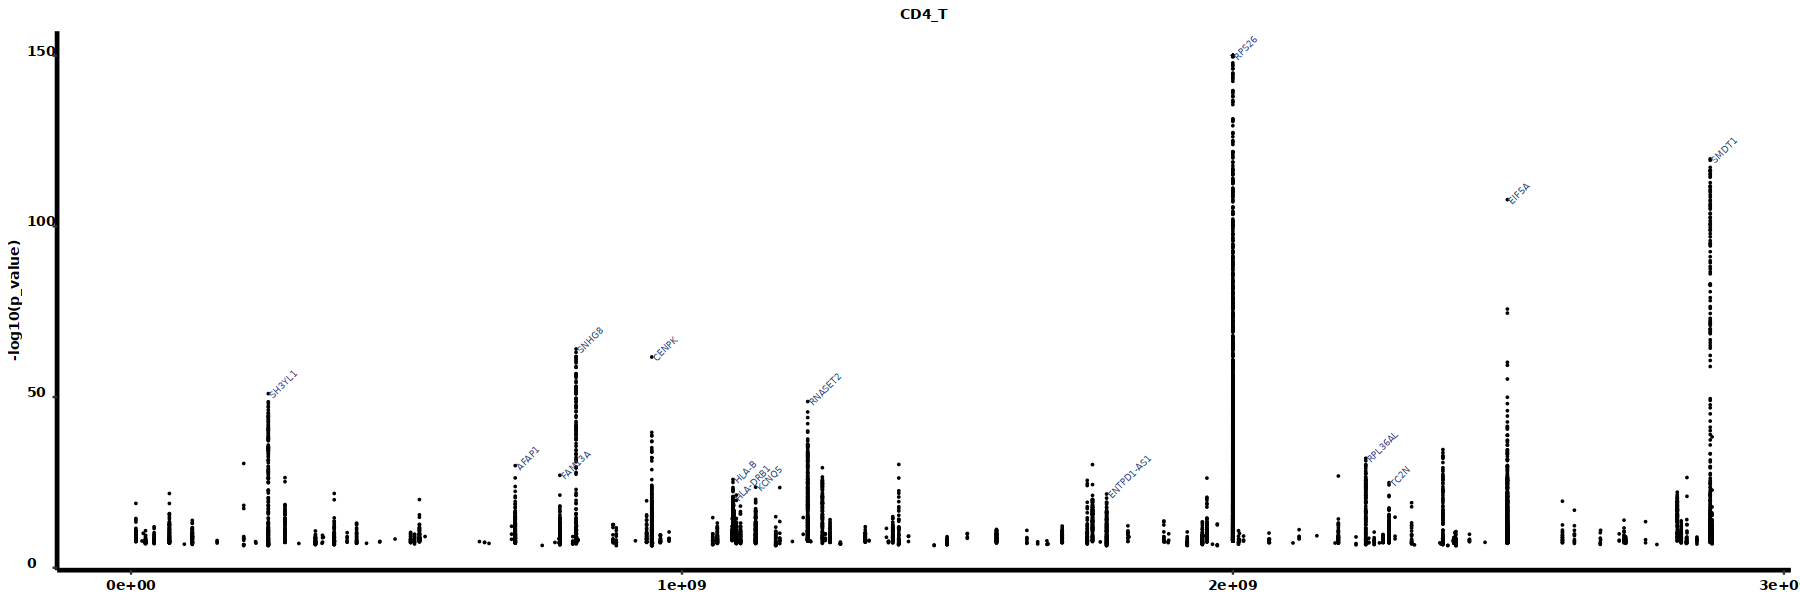

In [1833]:
options(repr.plot.width=15, repr.plot.height=5)
manhattanplot = ggplot(meta_results , aes(snp_pos_plot, -log10(p_value))) + geom_point(size = 0.0001) +
    scale_size_continuous(range = c(0.1, 1)) + theme(axis.text.x = element_blank(), axis.text.y = element_blank()) + plot_config  + scale_color_gradient(low = "lightblue", high = "blue") +
    geom_text(data = meta_results %>% dplyr::filter(amount_coegenes > limit) %>% group_by(eGene) %>% dplyr::filter(p_value == min(p_value)) %>%   slice_sample(n = 1),  # Filter to label only significant points
            aes(label = eGene),  # Replace 'snp_name' with the column containing labels
            hjust = 0, vjust = 1, size = 1.8, color =choose_color, angle = 45) + theme(axis.title.x = element_blank()) + ggtitle(cell_type)

manhattanplot

In [1835]:
## Modify axis ticks to show chromosome 

In [1836]:
manhattanplot = manhattanplot + 
  scale_x_continuous(
    limits = c(0, max(meta_results$cumulative_bp.x) + 50818468 ), 
      breaks = ticks_x_y$endpoint, labels = ticks_x_y$snp_chr
  ) + theme(axis.text.x = element_text(angle = 90)) + scale_y_continuous(expand = expansion(mult = c(0.05,0.2)))

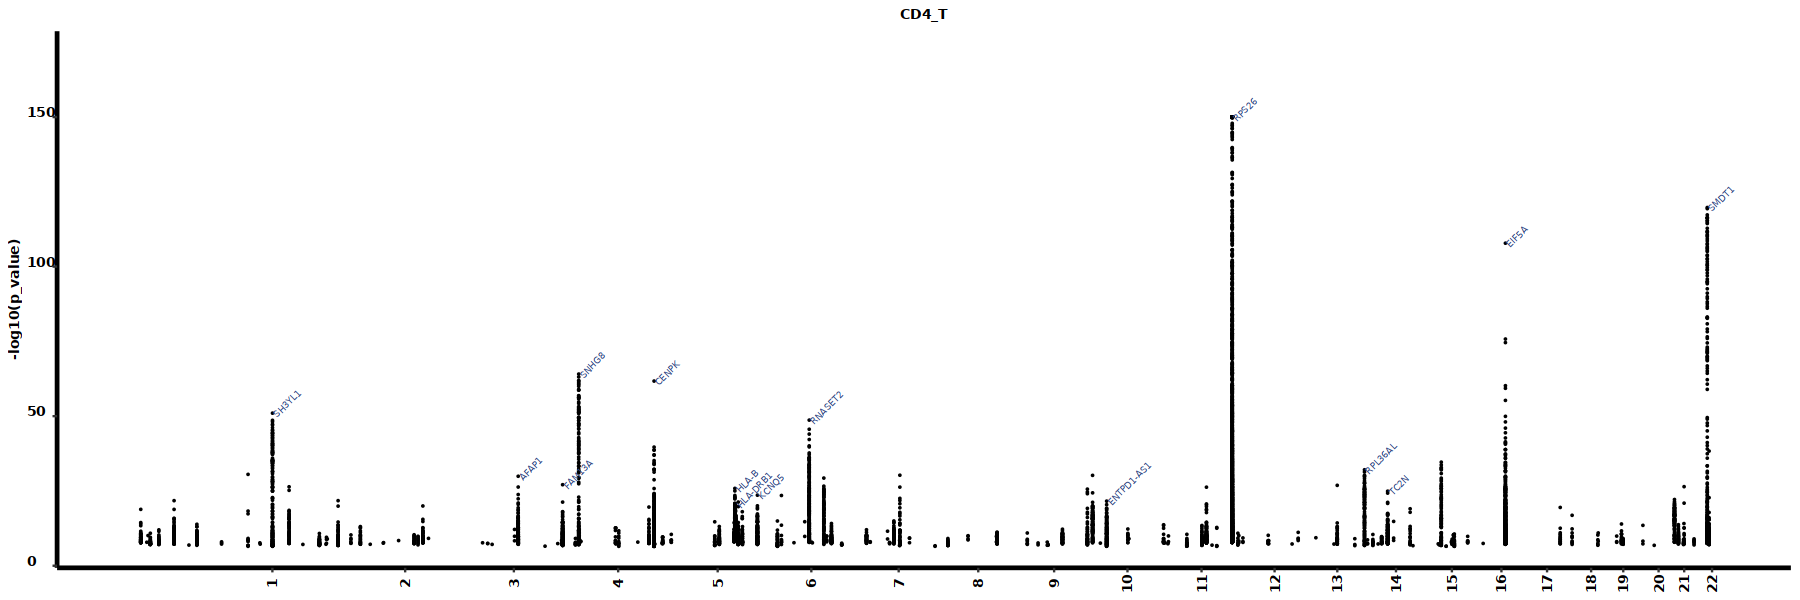

In [1837]:
manhattanplot

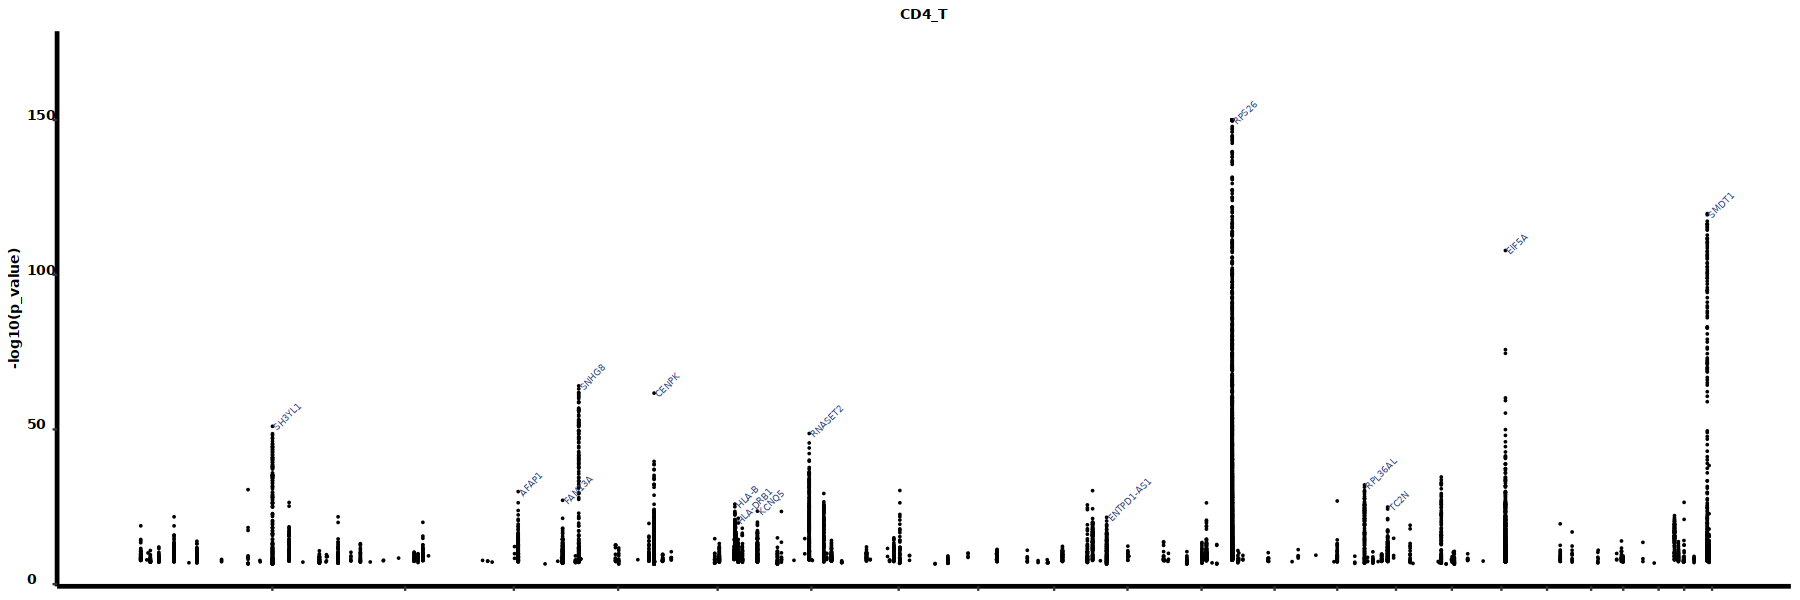

In [1838]:
manhattanplot + theme(axis.text.x = element_blank())

pdf 
  2

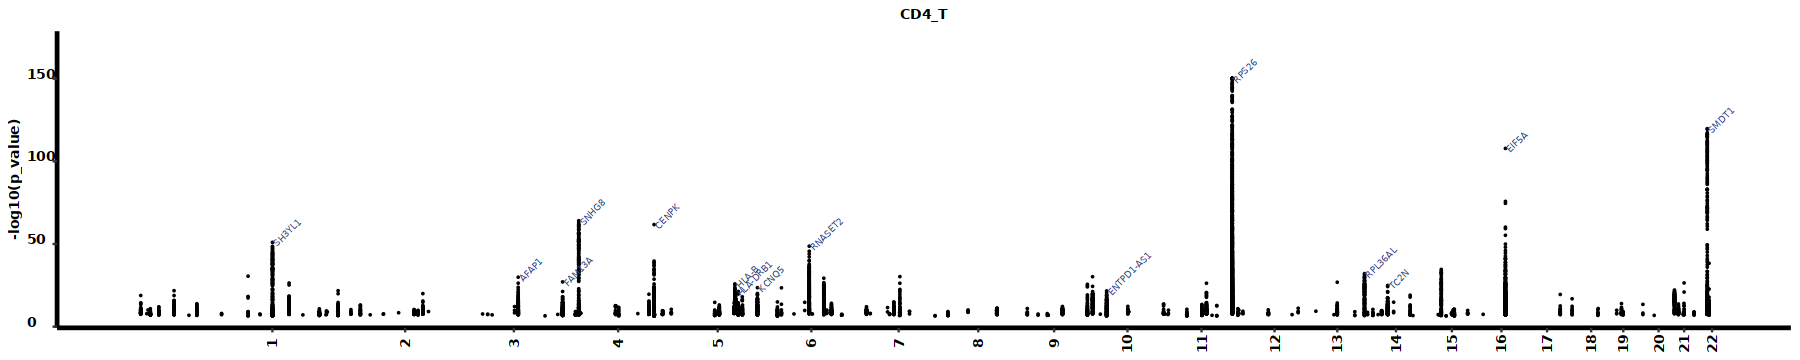

In [1839]:
options(repr.plot.width=15, repr.plot.height=3)

pdf(paste0('figures/F13/F13_Manhattanplot_', cell_type, n_rb_mt_filter, '.pdf'), width =4.3, height =1.7)
print(manhattanplot)
dev.off()

manhattanplot

In [1840]:
options(repr.plot.width=15, repr.plot.height=3)

pdf(paste0('figures/F13/F13_Manhattanplot_w_o_axis', cell_type, n_rb_mt_filter, '.pdf'), width =4.3, height =1.5)
print(manhattanplot + theme(axis.text.x = element_blank()))
dev.off()

pdf 
  2

In [1841]:
### save the data for manhattan plot

In [1842]:
write.csv(meta_results, paste0('figures/F13/F13_Manhattanplot_', cell_type, n_rb_mt_filter, '_data1.csv'))

In [1843]:
write.csv(ticks_x_y, paste0('figures/F13/F13_Manhattanplot_', cell_type, n_rb_mt_filter, '_data2.csv'))

In [1844]:
head(ticks_x_y,2)

,chr,cumulative_bp,snp_chr,midpoint,endpoint
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>
1,1,0,1,124478211,248956422
2,2,248956422,2,370053186,491149951
